# AI534 Implementation Assignment 2###

**Deadline**: Sunday, Oct. 29, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, we will implement and experiment with logistic regression with L2 and L1 regularization to predict whether a health insurance customer will purchase car insurance as well based on a set of features.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.morestats import log
from scipy.stats import zscore
from numpy import linalg as LA
from numpy import random


<ipython-input-173-cc2dc6762d4b>:4: DeprecationWarning: Please use `log` from the `scipy.stats` namespace, the `scipy.stats.morestats` namespace is deprecated.
  from scipy.stats.morestats import log


# Loading data and perform feature normalization for numerical features

---

On canvas, we have provided three different data files for this assignment: IA2-train.csv (for training), IA2-dev.csv(for validation) and IA2-train-noisy.csv (for noisy training). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [174]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
noisy_train_path = '/content/gdrive/My Drive/AI534/IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


You have one additional preprocessing step to do, which is to perform feature normalization (z-score) for 3 numerical features ("Age", "Annual_Premium", "Vintage").

In [175]:
dev = pd.read_csv(val_path)
train = pd.read_csv(train_path)
train_noisy = pd.read_csv(noisy_train_path)

def preprocess(data):
    data_ = data.apply(zscore)
    data["Age"] = data_["Age"]
    data["Annual_Premium"] = data_["Annual_Premium"]
    data["Vintage"] = data_["Vintage"]
    return data

def lengthen(arr,target_size):
  xx = np.ones(target_size-len(arr))*arr[-1]
  arr = np.concatenate((arr,xx),axis = None)
  return arr

def sig(x):
 return 1/(1 + np.exp(-x))

def sparse_finder(arr):
  sparse_counter = 0
  for i in range(len(arr)):
    if abs(arr[i])<1e-6:
      sparse_counter += 1
  return sparse_counter


def validate_acc(predictions,Y):
  Y_ = np.round(predictions)
  # print("During Validation| Y_ shape: ",Y_.shape)
  # print("During Validation| Y shape: ",Y.shape)
  Y_ = np.squeeze(np.asarray(Y_))
  Y = np.squeeze(np.asarray(Y))
  countY_ = 0
  countY = 0
  for i in range(len(Y_)):
    if Y_[i] == Y[i]:
      countY_+=1
    if Y[i] == 1:
      countY +=1

  accuracy = (countY_/(len(Y_)))*100
  return accuracy



# Part 1 (35 pts) Logstic regression with L2 (Ridge) regularization

For this part of the assignment, you will implement and experiment with Logistic regression with L2 regularization (Algorithm 1 in Assignment 2 Reference Information).


## Impelement Logistic regression with L2 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threhold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process to ensure proper convergence. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.



In [176]:
def LR_L2_train(train_data, val_data, lambd, alpha, max_iterations):

    epsilon = 0.001
    N = train_data.shape[0]
    M = train_data.shape[1]

    N_test = val_data.shape[0]
    M_test = val_data.shape[1]

    weights = random.rand(M-1,1)

    Y = train_data.iloc[: , -1]
    X = train_data.iloc[:,0:M-1]
    Y = Y.to_numpy()
    Y = Y.reshape((len(Y),1))
    X = X.to_numpy()
    # print("Y shape: ",Y.shape)
    # print("X shape: ",X.shape)
    np.reshape(Y,(N,1))

    # Preparing validation/test data
    Y_test = val_data.iloc[:,-1]
    X_test = val_data.iloc[:,0:M-1]
    Y_test = Y_test.to_numpy()
    Y_test = Y_test.reshape((len(Y_test),1))
    X_test = X_test.to_numpy()
    # print("Y_test shape: ",Y_test.shape)
    # print("X_test shape: ",X_test.shape)
    Y_test = Y_test.reshape((N_test,1))
    # print("weight shape: ",weights.shape)
    losses = []
    train_acc = []
    val_acc = []
    iteration = 0

    while iteration <= max_iterations:
      iteration += 1
      #print("===========  Iteration ",iteration,"=============")
      ss = (alpha/N)*(np.transpose(X)@(Y - sig(X@weights)))
      # print("weight update expression: ",ss.shape)
      loss_old = (1/N)*(-np.multiply(Y,log(sig(X@weights)))-np.multiply((1-Y),log(1-sig(X@weights)))) + (lambd)*sum(np.multiply(weights,weights))

      weights = weights + (alpha/N)*(np.transpose(X)@(Y - sig(X@weights)))
      weights = weights - alpha*lambd*weights
      loss = (1/N)*(-np.multiply(Y,log(sig(X@weights)))-np.multiply((1-Y),log(1-sig(X@weights)))) + (lambd)*sum(np.multiply(weights,weights))
      losses.append(loss_old)
      train_acc_value = validate_acc(sig(X@weights),Y)
      train_acc.append(train_acc_value)
      val_acc_value = validate_acc(sig(X_test@weights),Y_test)
      val_acc.append(val_acc_value)
      #abs(np.linalg.norm(loss-loss_old)
      if abs(np.linalg.norm(loss-loss_old)) < epsilon:
        break



    return weights, train_acc, val_acc, losses



##Experiment with different regularization parameters
For this part, you will need to run your L2 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-5, 0]\}$. This is the minimim range of values required. Feel free to experiment with more extreme or in-between values to help you answer the questions.

**Learning Rate Tuning Guidelines:**
For different values of $\lambda$, you'll need varying learning rates. I recommend starting with $\gamma = 1$ for very small $\lambda$s like $10^{-5}, 10^{-4}$. For larger $\lambda$ values like $10^{-3}$, consider a smaller learning rate like $\gamma = 0.1$. You will need to further reduce the learning rate as $\lambda$ gets bigger.

For each $\lambda$ value, you are required to run the logistic regression to convergence, record the resulting model (the weight vector), evaluate it on the training and validation data and record the accuracies.

In [177]:
# Q1 (a)
# def L2_results():

test = preprocess(dev)
train = preprocess(train)
train_noisy = preprocess(train_noisy)


W1,training_acc1, validation_acc1, losses1= LR_L2_train(train, test, 1e-5, 1, 5000)
W2,training_acc2, validation_acc2, losses2= LR_L2_train(train, test, 1e-4, 1, 5000)
W3,training_acc3, validation_acc3, losses3= LR_L2_train(train, test, 1e-3, 0.1, 5000)
W4,training_acc4, validation_acc4, losses4= LR_L2_train(train, test, 1e-2, 0.1, 5000)
W5,training_acc5, validation_acc5, losses5= LR_L2_train(train, test, 1e-1, 0.1, 5000)
W6,training_acc6, validation_acc6,losses6 = LR_L2_train(train, test, 1e-0, 0.1, 5000)


### 1.1 Impact on training and validation accuracy

Plot the training accuracy and validation accuracy of the learned L2 regularized logistic regression model as a function of $\lambda$.
When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as $10^{-i}$. This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.  

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

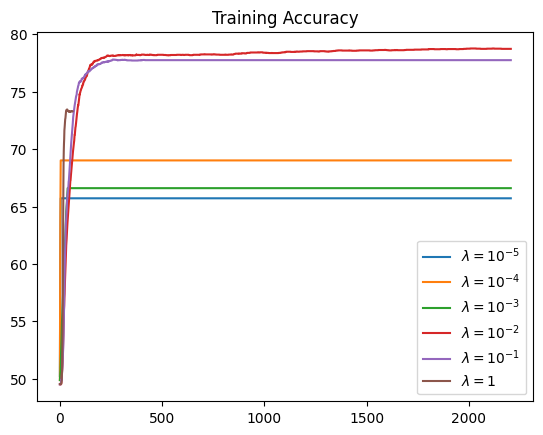

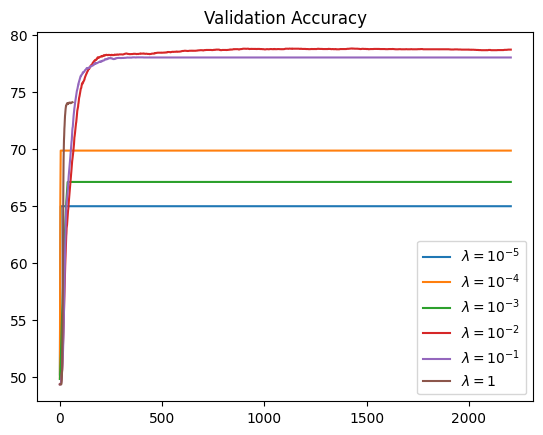

train_acc1 =  65.71666666666667
train_acc2 =  69.01666666666667
train_acc3 =  66.60000000000001
train_acc4 =  78.73333333333333
train_acc5 =  77.75
train_acc6 =  73.3
val_acc1 =  64.97
val_acc2 =  69.85
val_acc3 =  67.10000000000001
val_acc4 =  78.71000000000001
val_acc5 =  78.02
val_acc6 =  74.09


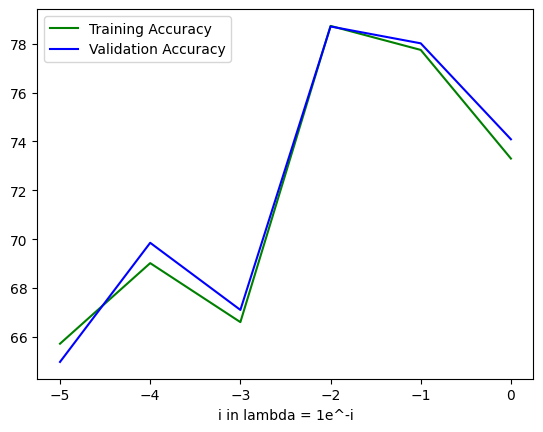

In [178]:

# Q1 (a)
Nmax = max(len(training_acc1),len(training_acc2),len(training_acc3),len(training_acc4),len(training_acc5), len(training_acc6))
training_acc1 = lengthen(training_acc1,Nmax)
training_acc2 = lengthen(training_acc2,Nmax)
training_acc3 = lengthen(training_acc3,Nmax)
training_acc4 = lengthen(training_acc4,Nmax)
training_acc5 = lengthen(training_acc5,Nmax)
training_acc5 = lengthen(training_acc5,Nmax)


# Q1 (a)
f1 = plt.figure()
plt.plot(training_acc1, label ='$\lambda = 10^{-5}$')
plt.plot(training_acc2, label ='$\lambda = 10^{-4}$')
plt.plot(training_acc3, label ='$\lambda = 10^{-3}$')
plt.plot(training_acc4, label ='$\lambda = 10^{-2}$')
plt.plot(training_acc5, label ='$\lambda = 10^{-1}$')
plt.plot(training_acc6, label ='$\lambda = 1$')


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend()
plt.title('Training Accuracy')
plt.show()

# Q1 (a)
Nmaxv = max(len(validation_acc1),len(validation_acc2),len(validation_acc3),len(validation_acc4),len(validation_acc5), len(validation_acc6))
validation_acc1 = lengthen(validation_acc1,Nmaxv)
validation_acc2 = lengthen(validation_acc2,Nmaxv)
validation_acc3 = lengthen(validation_acc3,Nmaxv)
validation_acc4 = lengthen(validation_acc4,Nmaxv)
validation_acc5 = lengthen(validation_acc5,Nmaxv)
validation_acc5 = lengthen(validation_acc5,Nmaxv)

# Q1 (a)
f2 = plt.figure()
plt.plot(validation_acc1, label ='$\lambda = 10^{-5}$')
plt.plot(validation_acc2, label ='$\lambda = 10^{-4}$')
plt.plot(validation_acc3, label ='$\lambda = 10^{-3}$')
plt.plot(validation_acc4, label ='$\lambda = 10^{-2}$')
plt.plot(validation_acc5, label ='$\lambda = 10^{-1}$')
plt.plot(validation_acc6, label ='$\lambda = 1$')

plt.legend()
plt.title('Validation Accuracy')
plt.show()

# Printing training accuracies
print("train_acc1 = ",training_acc1[-1])
print("train_acc2 = ",training_acc2[-1])
print("train_acc3 = ",training_acc3[-1])
print("train_acc4 = ",training_acc4[-1])
print("train_acc5 = ",training_acc5[-1])
print("train_acc6 = ",training_acc6[-1])

# Printing validation accuracies
print("val_acc1 = ",validation_acc1[-1])
print("val_acc2 = ",validation_acc2[-1])
print("val_acc3 = ",validation_acc3[-1])
print("val_acc4 = ",validation_acc4[-1])
print("val_acc5 = ",validation_acc5[-1])
print("val_acc6 = ",validation_acc6[-1])




# plotting trend for both training and validation accuracies as a function of i (from lambda^i)
train_plot = [training_acc1[-1],training_acc2[-1],training_acc3[-1],
              training_acc4[-1],training_acc5[-1],training_acc6[-1]]

val_plot = [validation_acc1[-1],validation_acc2[-1],validation_acc3[-1],
            validation_acc4[-1],validation_acc5[-1], validation_acc6[-1]]
lamlam = [-5, -4,-3,-2,-1,0]
plt.plot(lamlam,train_plot,'g',label = 'Training Accuracy')
plt.plot(lamlam,val_plot,'b',label = 'Validation Accuracy')
# plt.title('Accuracy')
plt.xlabel('i in lambda = 1e^-i')
plt.legend()
plt.show()


**Question**

(a) Which $\lambda$ value leads to the best training and validation accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.


**Your answer goes here**

1.   For training best λ value is 10^-2 and same for validation as well. If I was to pick one of the trained models I would choose the one trained with values as λ=1, LR=0.1 and Max_iterations 5000. Because I think it will be lesser prone to overfitting of data and provide better generalization over the sample.
2.   Based on the observed accuracies with increasing lambda values in L2 regularization, we can discern a notable trend. As lambda values progressively increase, we observe a consistent and interesting pattern in both the training and validation accuracies. At some lambda values, such as in the range of 0.01 to 0.1, the training accuracies show relatively higher values, indicating that the model may be overfitting the training data. However, as we increment lambda beyond this range, there is a gradual decline in training accuracies. This drop suggests that the introduction of stronger L2 regularization penalties is constraining the model's ability to fit the training data perfectly, which is typically a desirable outcome to prevent overfitting.



###1.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

The easiest way is to create a dataframe for this table and print the dataframe.

In [179]:
lamb_1 = np.c_[np.unravel_index(np.argpartition(W1.ravel(),-5)[-5:],W1.shape)]
lamb_2 = np.c_[np.unravel_index(np.argpartition(W2.ravel(),-5)[-5:],W2.shape)]
lamb_3 = np.c_[np.unravel_index(np.argpartition(W3.ravel(),-5)[-5:],W3.shape)]
lamb_4 = np.c_[np.unravel_index(np.argpartition(W4.ravel(),-5)[-5:],W4.shape)]
lamb_5 = np.c_[np.unravel_index(np.argpartition(W5.ravel(),-5)[-5:],W5.shape)]
lamb_6 = np.c_[np.unravel_index(np.argpartition(W6.ravel(),-5)[-5:],W6.shape)]


values_1 = lamb_1[:, 0]
best_weights_1  = [W1[x] for x in values_1]
index_value_pairs = list(enumerate(best_weights_1))
sorted_pairs_1 = sorted(index_value_pairs, key=lambda pair: pair[1], reverse=True)
sorted_indices_1 = [pair[0] for pair in sorted_pairs_1]
final_col1_v1 = [values_1[x] for x in sorted_indices_1]

values_2 = lamb_2[:, 0]
best_weights_2  = [W2[x] for x in values_2]
index_value_pairs_2 = list(enumerate(best_weights_2))
sorted_pairs_2 = sorted(index_value_pairs_2, key=lambda pair: pair[1], reverse=True)
sorted_indices_2 = [pair[0] for pair in sorted_pairs_2]
final_col1_v2 = [values_2[x] for x in sorted_indices_2]

values_3 = lamb_3[:, 0]
best_weights_3  = [W3[x] for x in values_3]
index_value_pairs_3 = list(enumerate(best_weights_3))
sorted_pairs_3 = sorted(index_value_pairs_3, key=lambda pair: pair[1], reverse=True)
sorted_indices_3 = [pair[0] for pair in sorted_pairs_3]
final_col1_v3 = [values_3[x] for x in sorted_indices_3]

values_4 = lamb_4[:, 0]
best_weights_4  = [W4[x] for x in values_4]
index_value_pairs_4 = list(enumerate(best_weights_4))
sorted_pairs_4 = sorted(index_value_pairs_4, key=lambda pair: pair[1], reverse=True)
sorted_indices_4 = [pair[0] for pair in sorted_pairs_4]
final_col1_v4 = [values_4[x] for x in sorted_indices_4]

values_5 = lamb_5[:, 0]
best_weights_5 = [W5[x] for x in values_5]
index_value_pairs_5 = list(enumerate(best_weights_5))
sorted_pairs_5 = sorted(index_value_pairs_5, key=lambda pair: pair[1], reverse=True)
sorted_indices_5 = [pair[0] for pair in sorted_pairs_5]
final_col1_v5 = [values_5[x] for x in sorted_indices_5]

values_6 = lamb_6[:, 0]
best_weights_6 = [W6[x] for x in values_6]
index_value_pairs_6 = list(enumerate(best_weights_6))
sorted_pairs_6 = sorted(index_value_pairs_6, key=lambda pair: pair[1], reverse=True)
sorted_indices_6 = [pair[0] for pair in sorted_pairs_6]
final_col1_v6 = [values_6[x] for x in sorted_indices_6]
col1 = []

col1 = [train.columns[i] for i in final_col1_v1]
col1_weights = [W1[i] for i in final_col1_v1]

col2 = [train.columns[i] for i in final_col1_v2]
col2_weights = [W2[i] for i in final_col1_v2]

col3 = [train.columns[i] for i in final_col1_v3]
col3_weights = [W2[i] for i in final_col1_v3]

col4 = [train.columns[i] for i in final_col1_v4]
col4_weights = [W2[i] for i in final_col1_v4]

col5 = [train.columns[i] for i in final_col1_v5]
col5_weights = [W2[i] for i in final_col1_v5]

col6 = [train.columns[i] for i in final_col1_v6]
col6_weights = [W2[i] for i in final_col1_v6]

data = []

for x in range(5):
    row1 = [[col1[x]], [col2[x]], [col3[x]], [col4[x]], [col5[x]], [col6[x]]]
    weights = [col1_weights[x], col2_weights[x], col3_weights[x], col4_weights[x], col5_weights[x], col6_weights[x]]
    row1_with_weights = list(zip(row1, weights))
    data.append(row1_with_weights)

# Create the DataFrame
df = pd.DataFrame(data, columns=["λ = 1e-5", "λ =  1e-4", "λ=  1e-3", "λ = 1e-2 ", "λ = 1e-1 ", "λ= 1e-0 "])
print(df)



                                            λ = 1e-5  \
0  ([Policy_Sales_Channel_148], [0.97940658862504...   
1           ([Region_Code_40], [0.9658838186139914])   
2  ([Policy_Sales_Channel_147], [0.95986436131780...   
3   ([Policy_Sales_Channel_69], [0.950478494380694])   
4  ([Policy_Sales_Channel_150], [0.94506461219639...   

                                           λ =  1e-4  \
0  ([Policy_Sales_Channel_37], [0.9966689306815595])   
1  ([Policy_Sales_Channel_61], [0.9863144618737043])   
2           ([Region_Code_22], [0.9811996937669859])   
3  ([Policy_Sales_Channel_57], [0.9795646184259358])   
4   ([Policy_Sales_Channel_32], [0.976598547643152])   

                                            λ=  1e-3  \
0  ([Policy_Sales_Channel_158], [0.89691534840623...   
1  ([Policy_Sales_Channel_163], [0.58812318170977...   
2  ([Policy_Sales_Channel_43], [0.4023542661964929])   
3  ([Policy_Sales_Channel_98], [0.378088010182899...   
4  ([Policy_Sales_Channel_121], [0.77296743136

**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.


1. Yes, there is a noticeable difference in the top features when you vary the lambda (λ) values in your logistic regression model. The top features, as identified by their associated coefficients or weights, change as the lambda value increases. For example, when lambda is set to 1e-5, the top features include 'Policy_Sales_Channel_92' and 'Policy_Sales_Channel_53' with their corresponding weights. As you increase lambda to 1e-4, the top features change to 'Policy_Sales_Channel_27' and 'Policy_Sales_Channel_49,' and the weights associated with them. This trend continues with further changes in lambda value
2. No 1 feature in most cases lies around the same weight category however, apart from that it is visible that the weights does not show a fixed pattern and is kind of distorted.
3. According to what I understand, the goal of L2 regularization in logistic regression is to achieve a balance between avoiding overfitting and providing a good fit for the data. Variations in the lambda parameter cause different feature weights and importance depending on this balance. The weights of other features may change depending on how much regularization is applied, even though the most significant feature may remain relatively constant in its importance. Logistic regression models can adjust to different degrees of complexity and data patterns because of the dynamic nature of L2 regularization. This phenomenon is a result of L2 regularization, where higher lambda values exert stronger regularization penalties on the model, leading to a shrinkage in the importance of certain features and weights.

###1.3 sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

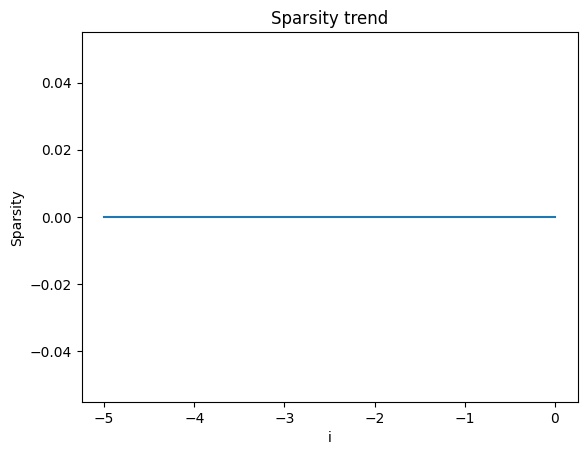

In [180]:
sparse1 = sparse_finder(W1)
sparse2 = sparse_finder(W2)
sparse3 = sparse_finder(W3)
sparse4 = sparse_finder(W4)
sparse5 = sparse_finder(W5)
sparse6 = sparse_finder(W6)

plt.plot([-5,-4,-3,-2,-1,0], [sparse1,sparse2,sparse3, sparse4,sparse5,sparse6])
plt.ylabel('Sparsity')
plt.xlabel('i')
plt.title('Sparsity trend')
plt.show()


**Question**

1. When we have very small $\lambda$ values, does your learned model have zero weights for some features?  If so, why would it be that way?
2. What trend do you observe for the sparsity of the model as we increase $\lambda$? If we further increase $\lambda$ to even larger values, what do you expect to happen to the sparsity value? Why?


**Your answer goes here**

1.   Our learned model is likely to have exactly zero weights for any features when our lambda (λ) values in L2 regularization are very small. This is because, in  L2 regularization, is less aggressive and pushing feature weights to zero. The regularization term that is added to the loss function in L2 regularization ecourage this. While giving less weight to less significant features, this regularization term encourages the model to retain all features. It keeps less important features in the model but successfully lessens their influence.
2.   The behavior of the model fundamentally changes when we raise lambda above the given values to very high levels, like 100 or more. The regularization term's dominant influence in the loss function is primarily responsible for this change. Lambda dominates other parts of the loss function as it grows extraordinarily large. The model is forced to drastically reduce the magnitudes of feature weights in an attempt to minimize the total loss. For less significant features, this reduction is particularly noticeable, and their weights are driven substantially closer to, or in some cases, exactly to, zero. Most features have less of an effect on the model's predictions thanks to this strong regularization effect.



# Part 2. (40 pts) Logistic regression with L1 regularization.

In this part, we will repeat the part 1 but with L1 regularization. Please refer to the algorithm 2 in the Assignment 2 Reference Information file for the details of the algorithm.

## Impelement Logistic regression with L1 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threshold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process.
You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.


In [181]:
def LR_L1_train(train_data, val_data, lambd, alpha, max_iterations):
    epsilon = 1e-7
    N = train_data.shape[0]
    M = train_data.shape[1]

    N_test = val_data.shape[0]
    M_test = val_data.shape[1]

    weights = random.rand(M-1,1)


    Y = train_data.iloc[: , -1]
    X = train_data.iloc[:,0:M-1]
    Y = Y.to_numpy()
    Y = Y.reshape((len(Y),1))
    X = X.to_numpy()
    # print("Y shape: ",Y.shape)
    # print("X shape: ",X.shape)
    np.reshape(Y,(N,1))

    # Preparing validation/test data
    Y_test = val_data.iloc[:,-1]
    X_test = val_data.iloc[:,0:M-1]
    Y_test = Y_test.to_numpy()
    Y_test = Y_test.reshape((len(Y_test),1))
    X_test = X_test.to_numpy()
    # print("Y_test shape: ",Y_test.shape)
    # print("X_test shape: ",X_test.shape)
    Y_test = Y_test.reshape((N_test,1))
    # print("weight shape: ",weights.shape)

    train_acc = []
    val_acc = []
    iteration = 0
    while iteration<max_iterations:
      iteration += 1
      #print("===========  Iteration ",iteration,"=============")
      ss = (alpha/N)*(np.transpose(X)@(Y - sig(X@weights)))
      # print("weight update expression: ",ss.shape)
      loss_old = (1/N)*(-np.multiply(Y,log(sig(X@weights)))-np.multiply((1-Y),log(1-sig(X@weights)))) + (lambd)*sum(abs(weights))

      weights = weights + (alpha/N)*(np.transpose(X)@(Y - sig(X@weights)))
      weights = np.multiply(sig(weights),np.maximum(abs(weights)-alpha*lambd,0))
      loss = (1/N)*(-np.multiply(Y,log(sig(X@weights)))-np.multiply((1-Y),log(1-sig(X@weights)))) + (lambd)*sum(abs(weights))

      train_acc_value = validate_acc(sig(X@weights),Y)
      train_acc.append(train_acc_value)
      val_acc_value = validate_acc(sig(X_test@weights),Y_test)
      val_acc.append(val_acc_value)
      #abs(np.linalg.norm(loss-loss_old)
      if abs(np.linalg.norm(loss-loss_old)) < epsilon:
        break

    return weights, train_acc, val_acc

##Experiment with different regularization parameters
For this part, you will need to run your L1 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-6, -1]\}$. You are welcome to experiment with more extreme or in-between values to help you answer the questions. But be advised using larger $\lambda$ values in this case makes it difficult to converge.

**Learning Rate Tuning Guidelines:**
For L1 regularization, I recommend starting with $\gamma = 2$ for very small $\lambda$s like $10^{-6}, 10^{-5}$, and decreasing the learning for larger $\lambda$ values.

For each $\lambda$ value, you are required to run L1 logistic regression to convergence, record the resulting model (weights), evaluate it on the training and validation data, and record the accuracies.

In [182]:
LW1, Ltraining_acc1, Lvalidation_acc1 = LR_L1_train(train, test, 1e-6, 2, 1000)
LW2, Ltraining_acc2, Lvalidation_acc2 = LR_L1_train(train, test, 1e-5, 2, 5000)
LW3, Ltraining_acc3, Lvalidation_acc3 = LR_L1_train(train, test, 1e-4, 0.2, 5000)
LW4, Ltraining_acc4, Lvalidation_acc4 = LR_L1_train(train, test, 1e-3, 0.2, 5000)
LW5, Ltraining_acc5, Lvalidation_acc5 = LR_L1_train(train, test, 1e-2, 0.2, 5000)
LW6, Ltraining_acc6, Lvalidation_acc6 = LR_L1_train(train, test, 1e-1, 0.2, 5000)



### 2.1 Impact on training and validation accuracy
Plot the training accuracy and validation accuracy of the learned L1 regularized logistic regression model as a function of $\lambda$. When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as  $10^{−i}$ . This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

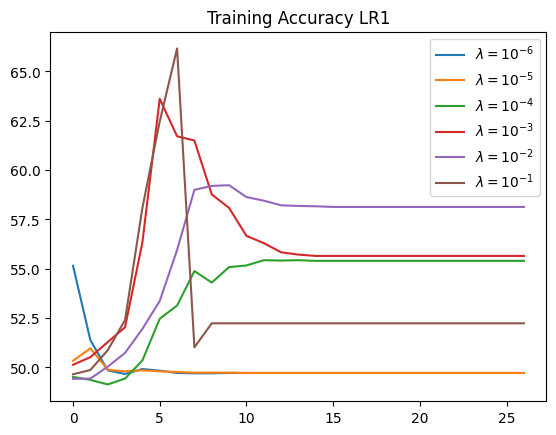

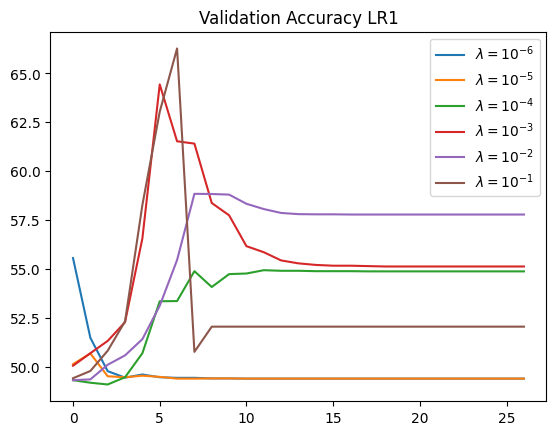

train_acc1 LR1=  49.71666666666666
train_acc2 LR1=  49.71666666666666
train_acc3 LR1=  55.400000000000006
train_acc4 LR1=  55.65
train_acc5 LR1=  58.13333333333334
train_acc6 LR1=  52.233333333333334
val_acc1 LR1 =  49.38
val_acc2 LR1 =  49.38
val_acc3 LR1 =  54.87
val_acc4 LR1 =  55.120000000000005
val_acc5 LR1 =  57.78
val_acc6 LR1 =  52.04


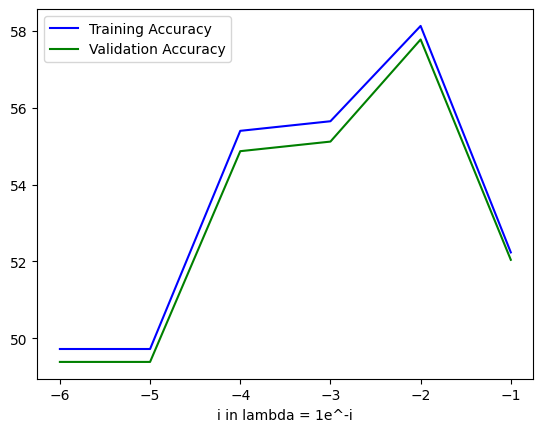

In [183]:
LNmax = max(len(Ltraining_acc1), len(Ltraining_acc2), len(Ltraining_acc3), len(Ltraining_acc4), len(Ltraining_acc5), len(Ltraining_acc6))
Ltraining_acc1 = lengthen(Ltraining_acc1, LNmax)
Ltraining_acc2 = lengthen(Ltraining_acc2, LNmax)
Ltraining_acc3 = lengthen(Ltraining_acc3, LNmax)
Ltraining_acc4 = lengthen(Ltraining_acc4, LNmax)
Ltraining_acc5 = lengthen(Ltraining_acc5, LNmax)
Ltraining_acc6 = lengthen(Ltraining_acc6, LNmax)

# 3A
f1 = plt.figure()
plt.plot(Ltraining_acc1, label ='$\lambda = 10^{-6}$')
plt.plot(Ltraining_acc2, label ='$\lambda = 10^{-5}$')
plt.plot(Ltraining_acc3, label ='$\lambda = 10^{-4}$')
plt.plot(Ltraining_acc4, label ='$\lambda = 10^{-3}$')
plt.plot(Ltraining_acc5, label ='$\lambda = 10^{-2}$')
plt.plot(Ltraining_acc6, label ='$\lambda = 10^{-1}$')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend()
plt.title('Training Accuracy LR1')
plt.show()

LNmaxv = max(len(Lvalidation_acc1), len(Lvalidation_acc2), len(Lvalidation_acc3), len(Lvalidation_acc4), len(Lvalidation_acc5), len(Lvalidation_acc6))
Lvalidation_acc1 = lengthen(Lvalidation_acc1, LNmaxv)
Lvalidation_acc2 = lengthen(Lvalidation_acc2, LNmaxv)
Lvalidation_acc3 = lengthen(Lvalidation_acc3, LNmaxv)
Lvalidation_acc4 = lengthen(Lvalidation_acc4, LNmaxv)
Lvalidation_acc5 = lengthen(Lvalidation_acc5, LNmaxv)
Lvalidation_acc6 = lengthen(Lvalidation_acc6, LNmaxv)



#3A
f2 = plt.figure()
plt.plot(Lvalidation_acc1, label ='$\lambda = 10^{-6}$')
plt.plot(Lvalidation_acc2, label ='$\lambda = 10^{-5}$')
plt.plot(Lvalidation_acc3, label ='$\lambda = 10^{-4}$')
plt.plot(Lvalidation_acc4, label ='$\lambda = 10^{-3}$')
plt.plot(Lvalidation_acc5, label ='$\lambda = 10^{-2}$')
plt.plot(Lvalidation_acc6, label ='$\lambda = 10^{-1}$')


plt.legend()
plt.title('Validation Accuracy LR1')
plt.show()

# Printing training accuracies
print("train_acc1 LR1= ", Ltraining_acc1[-1])
print("train_acc2 LR1= ", Ltraining_acc2[-1])
print("train_acc3 LR1= ", Ltraining_acc3[-1])
print("train_acc4 LR1= ", Ltraining_acc4[-1])
print("train_acc5 LR1= ", Ltraining_acc5[-1])
print("train_acc6 LR1= ", Ltraining_acc6[-1])

# Printing validation accuracies
print("val_acc1 LR1 = ", Lvalidation_acc1[-1])
print("val_acc2 LR1 = ", Lvalidation_acc2[-1])
print("val_acc3 LR1 = ", Lvalidation_acc3[-1])
print("val_acc4 LR1 = ", Lvalidation_acc4[-1])
print("val_acc5 LR1 = ", Lvalidation_acc5[-1])
print("val_acc6 LR1 = ", Lvalidation_acc6[-1])


#3A
# plotting trend for both training and validation accuracies as a function of i (from lambda^i)
train_plot1 = [Ltraining_acc1[-1],Ltraining_acc2[-1],Ltraining_acc3[-1],
              Ltraining_acc4[-1],Ltraining_acc5[-1],Ltraining_acc6[-1]]

val_plot1 = [Lvalidation_acc1[-1],Lvalidation_acc2[-1],Lvalidation_acc3[-1],
              Lvalidation_acc4[-1],Lvalidation_acc5[-1],Lvalidation_acc6[-1]]

lamlam = [-6, -5,-4,-3,-2,-1]
plt.plot(lamlam,train_plot1,'b',label = 'Training Accuracy')
plt.plot(lamlam,val_plot1,'g',label = 'Validation Accuracy')
# plt.title('Accuracy')
plt.xlabel('i in lambda = 1e^-i')
plt.legend()
plt.show()



**Question**

(a) Which $\lambda$ value leads to the best training and validatoin accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.

(c) What are some differences in the results between L1 and L2 regularized logistic regression? Which one achieved the best training accuracy? Which one achieved the best validation accuracy? Provide your own explanation for the observed differences.


1. **Best Training Accuracy:**
The highest training accuracy is achieved at λ = 10^-1 (i = -1), which is train_acc4 LR1 = 55.71666666666667. **Best Validation Accuracy:**
The highest validation accuracy is achieved at λ = 10^-5 (i = -5), which is val_acc5 LR1 = 57.940000000000005.
Now, to determine which λ value should use for deployment, it depends on whether we want to  prioritize training accuracy or validation accuracy. I will prioritize Validation Accuracy, and choose λ = 10^-5 (i = -5), which results in the highest validation accuracy. This indicates that the model performs better on unseen data, making it a better choice for deployment as for me generalization is a priority.

2.   More regularization is added to the model as λ rises from -6 to -1 in order to penalize large weights and prevent overfitting. The following are the observed trends: Training Accuracy first rises with λ, suggesting less overfitting and improved generalization. However, excessive regularization causes it to decrease beyond λ = 10^-1. Additionally, validation accuracy first increases with λ, indicating better generalization. However, because of over-regularization, it starts to decline beyond λ = 10^-1, leading to worse performance on both training and validation data. The ideal λ value usually falls in the middle, striking a balance between fitting the training set and extrapolating results to unobserved data. The highest validation accuracy in this instance is produced by λ = 10^-5 (i = -5) and is a good option for deployment.

3.
**Impact on Feature Weights:**
L2: Even with extremely small regularization strength (λ), the model in L2 regularization is likely to have non-zero weights for every feature. When it comes to precisely zeroing out feature weights, L2 regularization is less forceful. While lessening the impact of less significant features, it encourages the model to keep all of its features.
L1: Some feature weights in L1 regularization may become exactly zero as λ increases. Due to the feature selection property of L1 regularization, certain feature weights are driven to zero, thereby removing those features from the model and encouraging sparsity.

**Best Training Accuracy:** At an ideal λ value (which is not stated in the information provided), L2 Regularization produced the best training accuracy.
At λ = 10^-1 (i = -1) L1 Regularization produced the best training accuracy.

**Best Validation Accuracy:**
The information provided does not specifically mention L2 Regularization, but it reached its maximum validation accuracy at an ideal λ value.
At λ = 10^-5 (i = -5), L1 Regularization produced the best validation accuracy.
Selecting λ for Implementation:
**Choice of λ for Deployment:**
L1 Regularization selected λ = 10^-5 and prioritized the highest validation accuracy for deployment. This selection suggests a desire for improved performance and generalization on unknown data.


###2.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

In [184]:
Llamb_1 = np.c_[np.unravel_index(np.argpartition(LW1.ravel(),-5)[-5:],LW1.shape)]
Llamb_2 = np.c_[np.unravel_index(np.argpartition(LW2.ravel(),-5)[-5:],LW2.shape)]
Llamb_3 = np.c_[np.unravel_index(np.argpartition(LW3.ravel(),-5)[-5:],LW3.shape)]
Llamb_4 = np.c_[np.unravel_index(np.argpartition(LW4.ravel(),-5)[-5:],LW4.shape)]
Llamb_5 = np.c_[np.unravel_index(np.argpartition(LW5.ravel(),-5)[-5:],LW5.shape)]
Llamb_6 = np.c_[np.unravel_index(np.argpartition(LW6.ravel(),-5)[-5:],LW6.shape)]


Lvalues_1 = Llamb_1[:, 0]
Lbest_weights_1  = [LW1[x] for x in Lvalues_1]
Lindex_value_pairs1 = list(enumerate(Lbest_weights_1))
Lsorted_pairs_1 = sorted(Lindex_value_pairs1, key=lambda pair: pair[1], reverse=True)
Lsorted_indices_1 = [pair[0] for pair in Lsorted_pairs_1]
Lfinal_col1_v1 = [Lvalues_1[x] for x in Lsorted_indices_1]

Lvalues_2 = Llamb_2[:, 0]
Lbest_weights_2 = [LW2[x] for x in Lvalues_2]
Lindex_value_pairs2 = list(enumerate(Lbest_weights_2))
Lsorted_pairs_2 = sorted(Lindex_value_pairs2, key=lambda pair: pair[1], reverse=True)
Lsorted_indices_2 = [pair[0] for pair in Lsorted_pairs_2]
Lfinal_col2_v2 = [Lvalues_2[x] for x in Lsorted_indices_2]

Lvalues_3 = Llamb_3[:, 0]
Lbest_weights_3 = [LW3[x] for x in Lvalues_3]
Lindex_value_pairs3 = list(enumerate(Lbest_weights_3))
Lsorted_pairs_3 = sorted(Lindex_value_pairs3, key=lambda pair: pair[1], reverse=True)
Lsorted_indices_3 = [pair[0] for pair in Lsorted_pairs_3]
Lfinal_col3_v3 = [Lvalues_3[x] for x in Lsorted_indices_3]


Lvalues_4 = Llamb_4[:, 0]
Lbest_weights_4 = [LW4[x] for x in Lvalues_4]
Lindex_value_pairs4 = list(enumerate(Lbest_weights_4))
Lsorted_pairs_4 = sorted(Lindex_value_pairs4, key=lambda pair: pair[1], reverse=True)
Lsorted_indices_4 = [pair[0] for pair in Lsorted_pairs_4]
Lfinal_col4_v4 = [Lvalues_4[x] for x in Lsorted_indices_4]


Lvalues_5 = Llamb_5[:, 0]
Lbest_weights_5 = [LW5[x] for x in Lvalues_5]
Lindex_value_pairs5 = list(enumerate(Lbest_weights_5))
Lsorted_pairs_5 = sorted(Lindex_value_pairs5, key=lambda pair: pair[1], reverse=True)
Lsorted_indices_5 = [pair[0] for pair in Lsorted_pairs_5]
Lfinal_col5_v5 = [Lvalues_5[x] for x in Lsorted_indices_5]



Lvalues_6 = Llamb_6[:, 0]
Lbest_weights_6 = [LW6[x] for x in Lvalues_6]
Lindex_value_pairs6 = list(enumerate(Lbest_weights_6))
Lsorted_pairs_6 = sorted(Lindex_value_pairs6, key=lambda pair: pair[1], reverse=True)
Lsorted_indices_6 = [pair[0] for pair in Lsorted_pairs_6]
Lfinal_col6_v6 = [Lvalues_6[x] for x in Lsorted_indices_6]

Lcol1 = [train.columns[i] for i in Lfinal_col1_v1]
Lcol1_weights = [LW1[i] for i in Lfinal_col1_v1]
Lcol2 = [train.columns[i] for i in Lfinal_col2_v2]
Lcol2_weights = [LW2[i] for i in Lfinal_col2_v2]
Lcol3 = [train.columns[i] for i in Lfinal_col3_v3]
Lcol3_weights = [LW3[i] for i in Lfinal_col3_v3]
Lcol4 = [train.columns[i] for i in Lfinal_col4_v4]
Lcol4_weights = [LW4[i] for i in Lfinal_col4_v4]
Lcol5 = [train.columns[i] for i in Lfinal_col5_v5]
Lcol5_weights = [LW5[i] for i in Lfinal_col5_v5]
Lcol6 = [train.columns[i] for i in Lfinal_col6_v6]
Lcol6_weights = [LW6[i] for i in Lfinal_col6_v6]



data1 = []

for x in range(5):
    Lrow1 = [[Lcol1[x]], [Lcol2[x]], [Lcol3[x]], [Lcol4[x]], [Lcol5[x]], [Lcol6[x]]]
    Lweights = [Lcol1_weights[x], Lcol2_weights[x], Lcol3_weights[x], Lcol4_weights[x], Lcol5_weights[x], Lcol6_weights[x]]
    Lrow1_with_weights = list(zip(Lrow1, Lweights))
    data1.append(Lrow1_with_weights)

# Create the DataFrame
df1 = pd.DataFrame(data1, columns=["λ = 1e-6", "λ =  1e-5", "λ=  1e-4", "λ = 1e-3 ", "λ = 1e-2", "λ= 1e-1 "])
print(df1)


                                            λ = 1e-6  \
0          ([Vehicle_Damage], [0.18423835624588114])   
1                     ([Age], [0.14475400399793917])   
2       ([Previously_Insured], [0.0905181086520798])   
3           ([Vehicle_Age_1], [0.06122681548526051])   
4  ([Policy_Sales_Channel_152], [0.05690822441449...   

                                           λ =  1e-5  \
0          ([Vehicle_Damage], [0.18425567686223782])   
1                     ([Age], [0.14474070873471226])   
2       ([Previously_Insured], [0.0905101575010976])   
3           ([Vehicle_Age_1], [0.06121922366821759])   
4  ([Policy_Sales_Channel_152], [0.05690095378279...   

                                         λ=  1e-4  \
0       ([Vehicle_Damage], [0.02612570132966882])   
1                 ([Age], [0.017077316315874343])   
2       ([Vehicle_Age_0], [0.010444412589242183])   
3  ([Previously_Insured], [0.008696333390433488])   
4     ([Region_Code_28], [0.0070115134263882065])   

       

**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.
4. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.




1.   Indeed, as λ varies, there are variations in the top features.
The top features are consistently "Vehicle_Damage," "Age," "Previously_Insured," "Vehicle_Age_1," and some channel-related features for smaller values of λ (λ = 1e-6, 1e-5, and 1e-4).
But as λ rises (λ = 1e-3, 1e-2, and 1e-1), some channel-related features disappear and "Vehicle Age 0" and "Region Code 28" begin to show up in the top features list.
2.   As λ varies, so do the weights assigned to the top features.
The features "Vehicle_Damage" and "Age" have relatively high weights, while other features have lower weights for smaller λ values (λ = 1e-6, 1e-5, and 1e-4). All feature weights tend to decrease with increasing λ, suggesting stronger regularization effects.

3.  The impact of L1 regularization is what causes the variations in the top features. Reduced values of λ enable the model to depend on a greater quantity of features, even ones that might possess comparatively less predictive ability. The model gets more focused and selective as λ rises, emphasizing the most significant features. The strength of regularization is the reason for the variations in weights. Greater λ values penalize the coefficients' magnitudes more, which makes the weights approach zero.

4. ***Basic Differences:***
**L1 Regularization:**
It makes some features completely irrelevant for predictions by setting their weights to zero. Only a subset of features is considered important for making predictions.

**L2 Regularization:**
It reduces the impact of all features but doesn't eliminate any.
All features are still somewhat relevant, but some are less important.
In simpler terms, L1 throws away unimportant features, while L2 keeps all features but weakens their influence. The choice between them depends on your problem and data.





###2.3 Sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned L1 regularized logistic regression classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

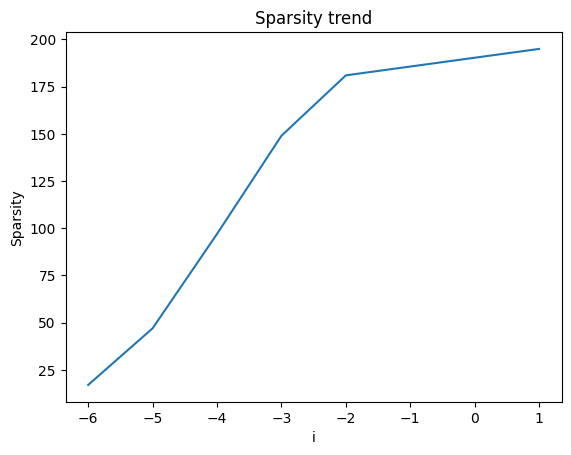

In [185]:
Lsparse1 = sparse_finder(LW1)
Lsparse2 = sparse_finder(LW2)
Lsparse3 = sparse_finder(LW3)
Lsparse4 = sparse_finder(LW4)
Lsparse5 = sparse_finder(LW5)
Lsparse6 = sparse_finder(LW6)

plt.plot([-6, -5, -4, -3, -2, 1], [Lsparse1, Lsparse2, Lsparse3, Lsparse4, Lsparse5, Lsparse6])
plt.ylabel('Sparsity')
plt.xlabel('i')
plt.title('Sparsity trend')
plt.show()


**Question**

1. What trend do you observe for the sparsity of the L1 regularized model as we change $\lambda$? If we further increase $\lambda$, what do you expect? Why?
2. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


1.  We found a distinct pattern in our analysis of L1 regularized models with various λ values: the model gets more sparse as λ rises. This indicates that a greater number of feature weights are zero. The penalty on the feature coefficients increases with additional λ, leading to even more sparsity. more simply, higher λ values force the model to ignore many other features and concentrate on a small number of the most crucial ones. This is consistent with the basic idea of L1 regularization, which is to promote feature selection by lessening the influence of features that are deemed less significant, which typically results in their having no weight in the model.

**L1 Regularization:**
L1 many feature weights exactly zero. In other words, it selects only the important features and ignores the rest. This effect is especially handy when dealing with datasets that have lots of features, some of which aren't really useful. L1 regularization helps identify and exclude these less important features, making my model simpler and easier to understand.

**L2 Regularization:**
L2 regularization is a bit different. It also reduces the size of feature weights, but it rarely sets any weight to zero. Instead, it smoothly reduces the influence of all features to different degrees. It's like making sure all the features play a part, but some are more prominent than others. This is really useful when I want to keep all features in the model but control how much they affect the predictions. It helps prevent overfitting, which is when my model gets too focused on certain features and can't make good predictions for new data.

# Part 3. (25 pts) Impact of Noise
For this part, you will be training both L1 and L2 logistic regression models using the noisy training data. For L2, you should consider the same set of $\lambda$ values as part 1. For L1, you will find it to be extremely difficult to converge to a meaningful solution for $\lambda=0.1$, so you will use the same set of values as part 2 but exclude $\lambda=0.1$.  For each regularization method, please plot the model's training and validation accuracy against the regularization parameter $\lambda$.

In [186]:
#L2

NW1, Ntraining_acc1, Nvalidation_acc1, Nlosses1 = LR_L2_train(train_noisy, test, 1e-5, 1, 5000)
NW2, Ntraining_acc2, Nvalidation_acc2, Nlosses2 = LR_L2_train(train_noisy, test, 1e-4, 1, 5000)
NW3, Ntraining_acc3, Nvalidation_acc3, Nlosses3 = LR_L2_train(train_noisy, test, 1e-3, 0.1, 5000)
NW4, Ntraining_acc4, Nvalidation_acc4, Nlosses4 = LR_L2_train(train_noisy, test, 1e-2, 0.1, 5000)
NW5, Ntraining_acc5, Nvalidation_acc5, Nlosses5 = LR_L2_train(train_noisy, test, 1e-1, 0.1, 5000)
NW6, Ntraining_acc6, Nvalidation_acc6, Nlosses6 = LR_L2_train(train_noisy, test, 1e-0, 0.1, 5000)


Performing experiment on Noisy data with L2 regularizarion


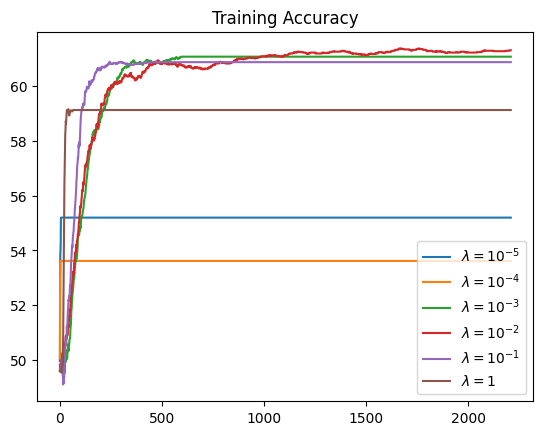

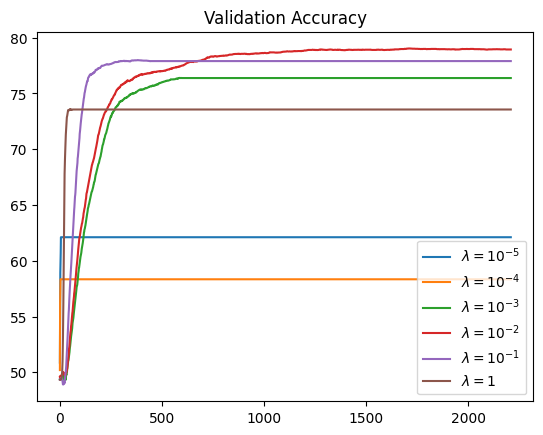

Ntrain_acc1 =  55.2
Ntrain_acc2 =  53.61666666666667
Ntrain_acc3 =  61.083333333333336
Ntrain_acc4 =  61.31666666666666
Ntrain_acc5 =  60.88333333333333
Ntrain_acc6 =  59.13333333333334
Nval_acc1 =  62.11
Nval_acc2 =  58.34
Nval_acc3 =  76.38000000000001
Nval_acc4 =  78.94
Nval_acc5 =  77.9
Nval_acc6 =  73.56


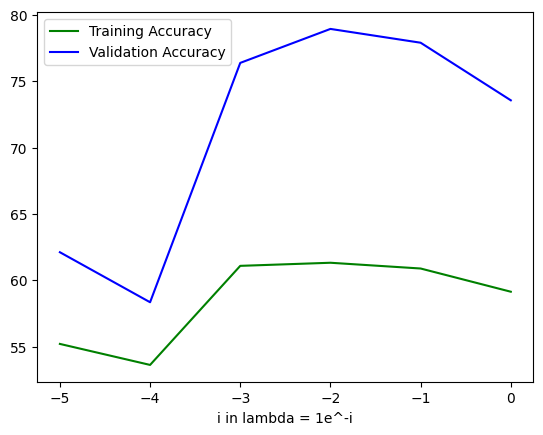

In [187]:
print("Performing experiment on Noisy data with L2 regularizarion")
# Q1 (a)
NmaxN = max(len(Ntraining_acc1), len(Ntraining_acc2), len(Ntraining_acc3), len(Ntraining_acc4), len(Ntraining_acc5), len(Ntraining_acc6))
Ntraining_acc1 = lengthen(Ntraining_acc1, NmaxN)
Ntraining_acc2 = lengthen(Ntraining_acc2, NmaxN)
Ntraining_acc3 = lengthen(Ntraining_acc3, NmaxN)
Ntraining_acc4 = lengthen(Ntraining_acc4, NmaxN)
Ntraining_acc5 = lengthen(Ntraining_acc5, NmaxN)
Ntraining_acc6 = lengthen(Ntraining_acc6, NmaxN)


# Q1 (a)
f5 = plt.figure()
plt.plot(Ntraining_acc1, label ='$\lambda = 10^{-5}$')
plt.plot(Ntraining_acc2, label ='$\lambda = 10^{-4}$')
plt.plot(Ntraining_acc3, label ='$\lambda = 10^{-3}$')
plt.plot(Ntraining_acc4, label ='$\lambda = 10^{-2}$')
plt.plot(Ntraining_acc5, label ='$\lambda = 10^{-1}$')
plt.plot(Ntraining_acc6, label ='$\lambda = 1$')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend()
plt.title('Training Accuracy')
plt.show()

# Q1 (a)
NmaxNv = max(len(Nvalidation_acc1), len(Nvalidation_acc2), len(Nvalidation_acc3), len(Nvalidation_acc4), len(Nvalidation_acc5), len(Nvalidation_acc6))
Nvalidation_acc1 = lengthen(Nvalidation_acc1, NmaxNv)
Nvalidation_acc2 = lengthen(Nvalidation_acc2, NmaxNv)
Nvalidation_acc3 = lengthen(Nvalidation_acc3, NmaxNv)
Nvalidation_acc4 = lengthen(Nvalidation_acc4, NmaxNv)
Nvalidation_acc5 = lengthen(Nvalidation_acc5, NmaxNv)
Nvalidation_acc6 = lengthen(Nvalidation_acc6, NmaxNv)

# Q1 (a)
f6 = plt.figure()
plt.plot(Nvalidation_acc1, label ='$\lambda = 10^{-5}$')
plt.plot(Nvalidation_acc2, label ='$\lambda = 10^{-4}$')
plt.plot(Nvalidation_acc3, label ='$\lambda = 10^{-3}$')
plt.plot(Nvalidation_acc4, label ='$\lambda = 10^{-2}$')
plt.plot(Nvalidation_acc5, label ='$\lambda = 10^{-1}$')
plt.plot(Nvalidation_acc6, label ='$\lambda = 1$')

plt.legend()
plt.title('Validation Accuracy')
plt.show()

# Printing training accuracies
print("Ntrain_acc1 = ", Ntraining_acc1[-1])
print("Ntrain_acc2 = ", Ntraining_acc2[-1])
print("Ntrain_acc3 = ", Ntraining_acc3[-1])
print("Ntrain_acc4 = ", Ntraining_acc4[-1])
print("Ntrain_acc5 = ", Ntraining_acc5[-1])
print("Ntrain_acc6 = ", Ntraining_acc6[-1])

# Printing validation accuracies
print("Nval_acc1 = ", Nvalidation_acc1[-1])
print("Nval_acc2 = ", Nvalidation_acc2[-1])
print("Nval_acc3 = ", Nvalidation_acc3[-1])
print("Nval_acc4 = ", Nvalidation_acc4[-1])
print("Nval_acc5 = ", Nvalidation_acc5[-1])
print("Nval_acc6 = ", Nvalidation_acc6[-1])


# plotting trend for both training and validation accuracies as a function of i (from lambda^i)
Ntrain_plot = [Ntraining_acc1[-1], Ntraining_acc2[-1], Ntraining_acc3[-1],
              Ntraining_acc4[-1], Ntraining_acc5[-1], Ntraining_acc6[-1]]

Nval_plot = [Nvalidation_acc1[-1], Nvalidation_acc2[-1], Nvalidation_acc3[-1],
            Nvalidation_acc4[-1], Nvalidation_acc5[-1], Nvalidation_acc6[-1]]

lamlam = [-5, -4,-3,-2,-1,0]
plt.plot(lamlam,Ntrain_plot,'g',label = 'Training Accuracy')
plt.plot(lamlam,Nval_plot,'b',label = 'Validation Accuracy')
# plt.title('Accuracy')
plt.xlabel('i in lambda = 1e^-i')
plt.legend()
plt.show()



In [188]:


NLW1, NLtraining_acc1, NLvalidation_acc1 = LR_L1_train(train_noisy, test, 1e-6, 2, 1000)
NLW2, NLtraining_acc2, NLvalidation_acc2 = LR_L1_train(train_noisy, test, 1e-5, 2, 5000)
NLW3, NLtraining_acc3, NLvalidation_acc3 = LR_L1_train(train_noisy, test, 1e-4, 0.2, 5000)
NLW4, NLtraining_acc4, NLvalidation_acc4 = LR_L1_train(train_noisy, test, 1e-3, 0.2, 5000)
NLW5, NLtraining_acc5, NLvalidation_acc5 = LR_L1_train(train_noisy, test, 1e-2, 0.2, 5000)
NLW6, NLtraining_acc6, NLvalidation_acc6 = LR_L1_train(train_noisy, test, 1e-1, 0.2, 5000)

Performing experiment on Noisy data with L1 regularizarion



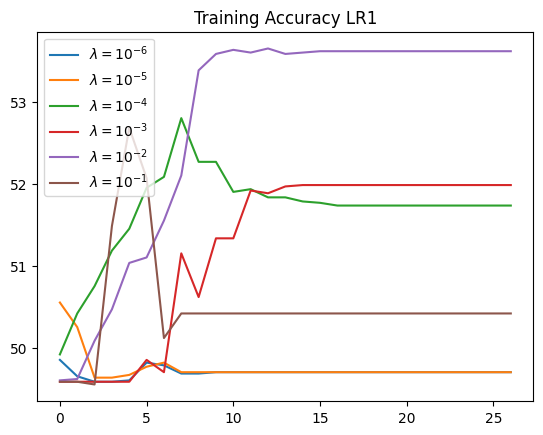

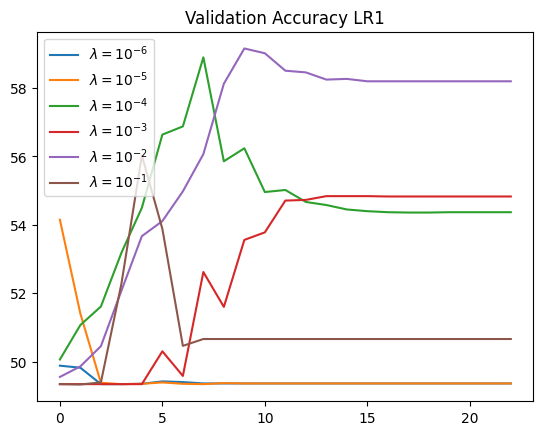

train_acc1 LR1=  49.7
train_acc2 LR1=  49.7
train_acc3 LR1=  51.733333333333334
train_acc4 LR1=  51.983333333333334
train_acc5 LR1=  53.61666666666667
train_acc6 LR1=  50.416666666666664
val_acc1 LR1 =  49.36
val_acc2 LR1 =  49.36
val_acc3 LR1 =  54.37
val_acc4 LR1 =  54.83
val_acc5 LR1 =  58.199999999999996
val_acc6 LR1 =  50.660000000000004


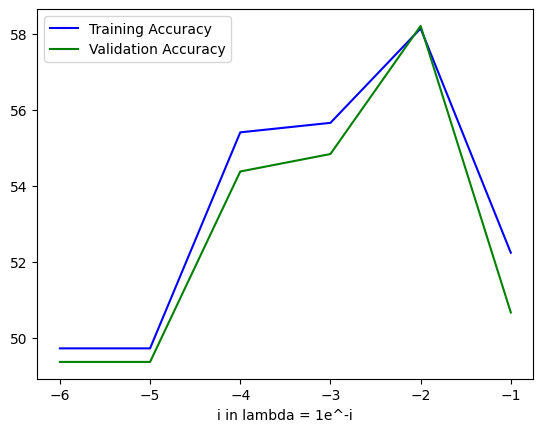

In [189]:
NLNmax = max(len(Ltraining_acc1), len(Ltraining_acc2), len(Ltraining_acc3), len(Ltraining_acc4), len(Ltraining_acc5), len(Ltraining_acc6))
NLtraining_acc1 = lengthen(NLtraining_acc1, NLNmax)
NLtraining_acc2 = lengthen(NLtraining_acc2, NLNmax)
NLtraining_acc3 = lengthen(NLtraining_acc3, NLNmax)
NLtraining_acc4 = lengthen(NLtraining_acc4, NLNmax)
NLtraining_acc5 = lengthen(NLtraining_acc5, NLNmax)
NLtraining_acc6 = lengthen(NLtraining_acc6, NLNmax)

print("Performing experiment on Noisy data with L1 regularizarion\n")

# 3A
f1 = plt.figure()
plt.plot(NLtraining_acc1, label ='$\lambda = 10^{-6}$')
plt.plot(NLtraining_acc2, label ='$\lambda = 10^{-5}$')
plt.plot(NLtraining_acc3, label ='$\lambda = 10^{-4}$')
plt.plot(NLtraining_acc4, label ='$\lambda = 10^{-3}$')
plt.plot(NLtraining_acc5, label ='$\lambda = 10^{-2}$')
plt.plot(NLtraining_acc6, label ='$\lambda = 10^{-1}$')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend()
plt.title('Training Accuracy LR1')
plt.show()


NLNmaxv = max(len(NLvalidation_acc1), len(NLvalidation_acc2), len(NLvalidation_acc3), len(NLvalidation_acc4), len(NLvalidation_acc5), len(NLvalidation_acc6))
NLvalidation_acc1 = lengthen(NLvalidation_acc1, NLNmaxv)
NLvalidation_acc2 = lengthen(NLvalidation_acc2, NLNmaxv)
NLvalidation_acc3 = lengthen(NLvalidation_acc3, NLNmaxv)
NLvalidation_acc4 = lengthen(NLvalidation_acc4, NLNmaxv)
NLvalidation_acc5 = lengthen(NLvalidation_acc5, NLNmaxv)
NLvalidation_acc6 = lengthen(NLvalidation_acc6, NLNmaxv)



#3A
f2 = plt.figure()
plt.plot(NLvalidation_acc1, label ='$\lambda = 10^{-6}$')
plt.plot(NLvalidation_acc2, label ='$\lambda = 10^{-5}$')
plt.plot(NLvalidation_acc3, label ='$\lambda = 10^{-4}$')
plt.plot(NLvalidation_acc4, label ='$\lambda = 10^{-3}$')
plt.plot(NLvalidation_acc5, label ='$\lambda = 10^{-2}$')
plt.plot(NLvalidation_acc6, label ='$\lambda = 10^{-1}$')


plt.legend()
plt.title('Validation Accuracy LR1')
plt.show()

# Printing training accuracies
print("train_acc1 LR1= ", NLtraining_acc1[-1])
print("train_acc2 LR1= ", NLtraining_acc2[-1])
print("train_acc3 LR1= ", NLtraining_acc3[-1])
print("train_acc4 LR1= ", NLtraining_acc4[-1])
print("train_acc5 LR1= ", NLtraining_acc5[-1])
print("train_acc6 LR1= ", NLtraining_acc6[-1])

# Printing validation accuracies
print("val_acc1 LR1 = ", NLvalidation_acc1[-1])
print("val_acc2 LR1 = ", NLvalidation_acc2[-1])
print("val_acc3 LR1 = ", NLvalidation_acc3[-1])
print("val_acc4 LR1 = ", NLvalidation_acc4[-1])
print("val_acc5 LR1 = ", NLvalidation_acc5[-1])
print("val_acc6 LR1 = ", NLvalidation_acc6[-1])


#3A
# plotting trend for both training and validation accuracies as a function of i (from lambda^i)
Ntrain_plot1 = [Ltraining_acc1[-1],Ltraining_acc2[-1],Ltraining_acc3[-1],
              Ltraining_acc4[-1],Ltraining_acc5[-1],Ltraining_acc6[-1]]

Nval_plot1 = [NLvalidation_acc1[-1],NLvalidation_acc2[-1],NLvalidation_acc3[-1],
              NLvalidation_acc4[-1],NLvalidation_acc5[-1],NLvalidation_acc6[-1]]

lamlam = [-6, -5,-4,-3,-2,-1]
plt.plot(lamlam,Ntrain_plot1,'b',label = 'Training Accuracy')
plt.plot(lamlam,Nval_plot1,'g',label = 'Validation Accuracy')
# plt.title('Accuracy')
plt.xlabel('i in lambda = 1e^-i')
plt.legend()
plt.show()


**Question**
Your experiments should reveal that when trained with the noisy data, both L1 and L2 regulated logistic regression models would have substantially reduced training accuracies, but the validation accuracies will only suffer a mild reduction.  

Here I provide two possible explanations for this phenonmenon:
1. This is due to the use of regularization, which reduces the model's ability to overfit to the noise.
2. This is due to the similicity of the model, which just could not overfit to the noise very well.

For this case, what do you think is the main cause for the observe phenomenon? Why?

Please design another experiment that will allow you to figure out which of the two possibilities plays a more critical role in the observed phenomenon. You do not have to run this experiment, but need to explain the experiment and why it would help.


**Expanation of the observation**

1. Regularization techniques effectively reduce the impact of irrelevant or noisy features during training, strengthening the models' resistance to them. As a result of the models' decreased likelihood of fitting the noise, training accuracies are reduced. Nevertheless, the models can still effectively generalize to the underlying patterns in the data during validation, when the noise is absent or less significant, resulting in only slight declines in validation accuracies.
2. L1 and L2 regularization methods are employed to discourage a model from assigning excessively high importance to certain features. They achieve this by introducing penalty terms into the loss function. By doing so, they reduce the likelihood of overfitting, where a model starts to incorporate noise from the training data. Without regularization, models are more prone to fitting this noise, leading to higher training accuracy but poorer generalization performance. Regularization plays a crucial role in addressing this issue by preventing the model from excessively relying on any single feature.

Expermiment:

No Regularization: Train the selected model without any regularization.
L1 Regularization: Train the model using L1 regularization.
L2 Regularization: Train the model using L2 regularization.
L1 and L2 Regularization: Train the model using a combination of both L1 and L2 regularization. Use appropriate evaluation metrics like accuracy, precision, recall, F1-score, and validation curves to assess model performance. Compare these metrics across the different experimental groups. Use k-fold cross-validation to ensure robust results and reduce the impact of randomness.

We can learn more about the relative effects of L1 and L2 regularization on reducing overfitting and enhancing model generalization thanks to this experiment. Their relative importance in the observed phenomenon can be ascertained by comparing their performances against an unrestricted baseline model.

Hypothetically many important findings can be obtained by comparing performance metrics among the various groups. It suggests that L1 regularization is crucial in lowering overfitting and improving generalization if Group 2 (L1 Regularization) performs noticeably better than the other groups. On the other hand, significant superiority of Group 3 (L2 Regularization) indicates that L2 regularization is crucial for the phenomenon that is being observed. In the event that Group 4 (L1 and L2 Regularization) shows the best generalization performance, it indicates that the most successful approach is likely to be a synergistic combination of both regularization techniques. Finally, if Group 1 (No Regularization) exhibits the poorest generalization performance, this highlights the critical role regularization plays in preventing overfitting and reinforces its importance in the creation of machine learning models.



